<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas, así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación para comprimir imágenes](#ej2)**: clustering y análisis.
 - **[Aplicación de reducción de dimensionalidad para resolver un problema de optimización](#ej3)**: t-SNE.

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de que se indique explícitamente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: </strong>  Kevin Luna Obando
</div>

Iniciamos la activdad con la carga de las siguientes librerías:

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.cluster import KMeans        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
random_state = 170

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento, ajustándolas a distintos conjuntos de datos.

El objetivo es doble: 
- entender la influencia de los parámetros en su comportamiento, 
- y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es encontrar las estructuras descritas por las variables *y* a través de los distintos modelos de *clustering* conseguir.

/tmp/ipykernel_2440521/390781755.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')


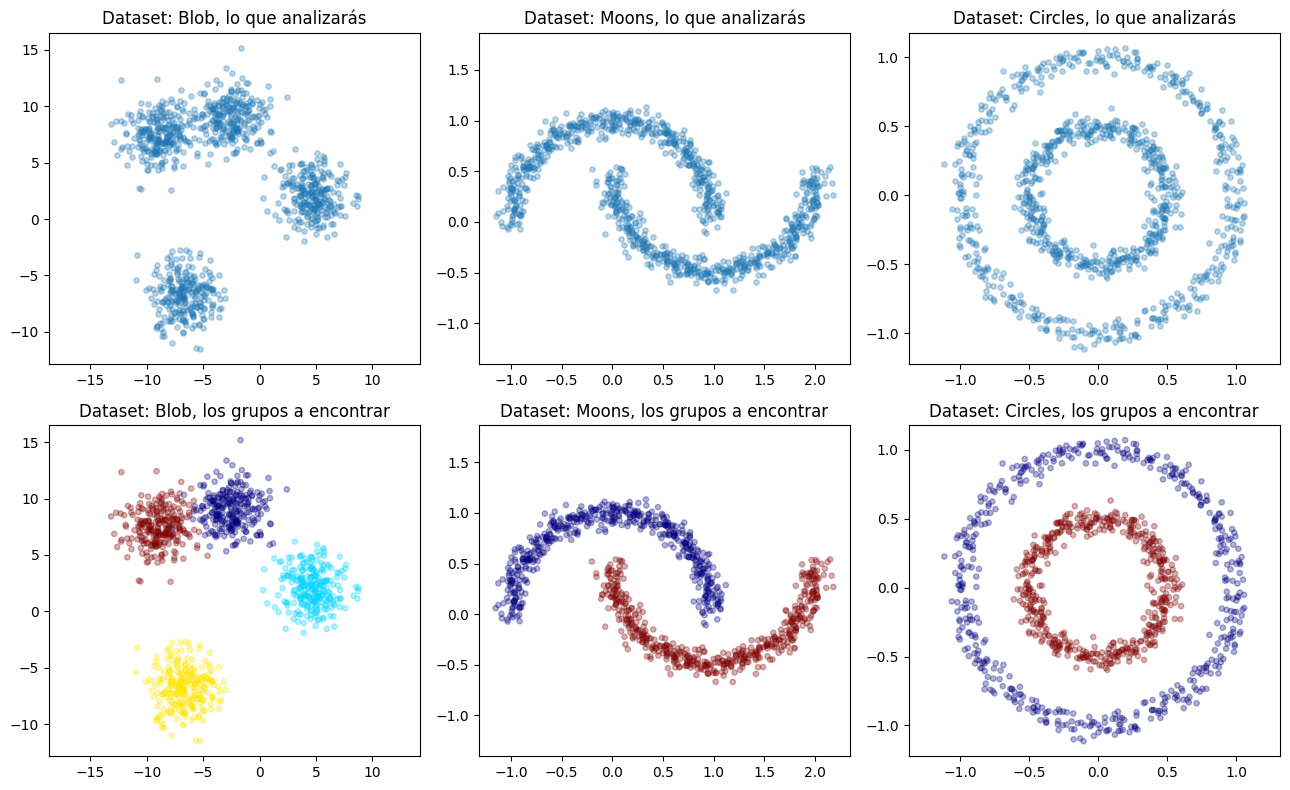

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [5]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

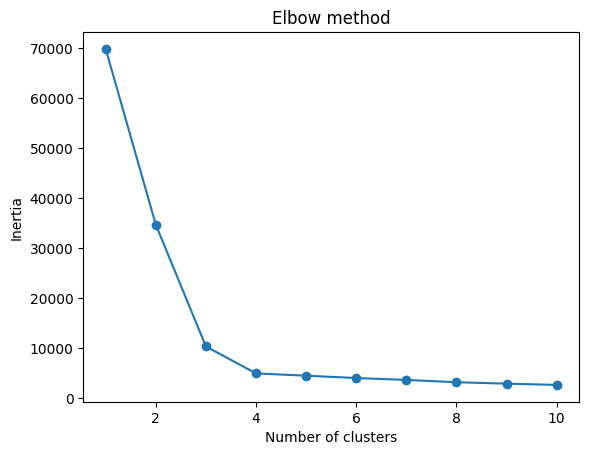

In [6]:
def elbow_method(X):
    inertias = []

    for i in range(1,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1,11), inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿Cómo podría mejorarse la elección de $k$?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">La interpretación de la gráfica del método del codo es la siguiente: el eje x representa el número de clusters, mientras que el eje y representa los valores de inercia que miden cuánto se alejan los puntos dentro de un cluster de su centroide. La curva de la gráfica típicamente muestra una caída abrupta al principio y luego comienza a estabilizarse después de un cierto número de clusters. El punto donde la curva comienza a estabilizarse se llama "punto de codo". Este punto indica que agregar más clusters no conduce a una mejora significativa en el rendimiento del clustering, y agregar muy pocos clusters resulta en un rendimiento de clustering deficiente. Por lo tanto, el número óptimo de clusters se estima visualmente al seleccionar el número de clusters en el punto de codo.

En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=3. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 3.

Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.</div>

In [7]:
from sklearn.metrics import silhouette_score
def silhouette_method(X):
    for i in range(2,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        cluster=kmeans.labels_
        silouhette_score = silhouette_score(X,cluster)
        print("Silhouette score: {:.3f} (k = {})".format(silouhette_score, i))

silhouette_method(X)

Silhouette score: 0.549 (k = 2)
Silhouette score: 0.681 (k = 3)
Silhouette score: 0.668 (k = 4)
Silhouette score: 0.570 (k = 5)
Silhouette score: 0.453 (k = 6)
Silhouette score: 0.370 (k = 7)
Silhouette score: 0.324 (k = 8)
Silhouette score: 0.327 (k = 9)
Silhouette score: 0.333 (k = 10)


<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando este método podemos observar que tanto k=3 y k=4 son buenas opciones.</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

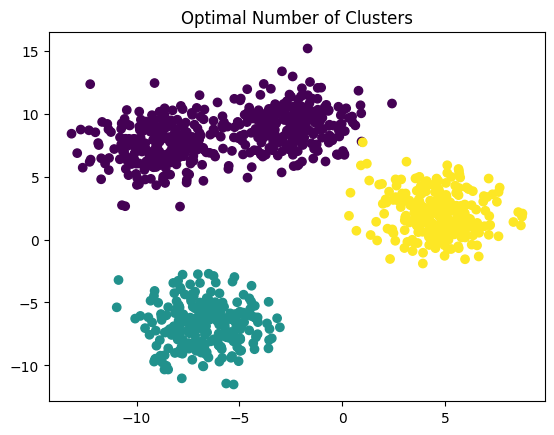

In [8]:
y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Podemos observar que el número adecuado de clúteres es 4. Uno de los motivos por el cual el metodo del codo no ha funcionado adecuadamente puede ser por el solpamiento de grupos, ya que no se puede observa una clara frontera entre los dos grupos de arriba.
Con una k=4 el clustering resultaría:</div>

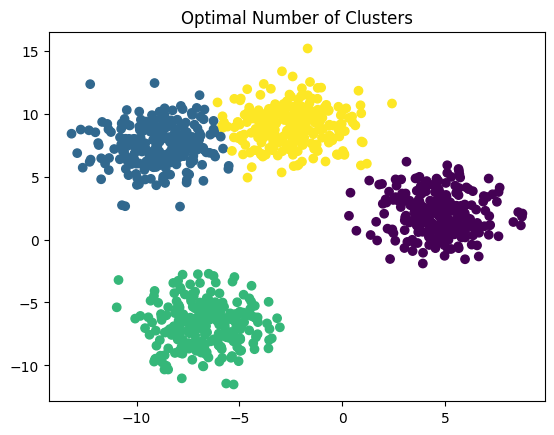

In [9]:
y_pred = KMeans(n_clusters=4).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

In [10]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

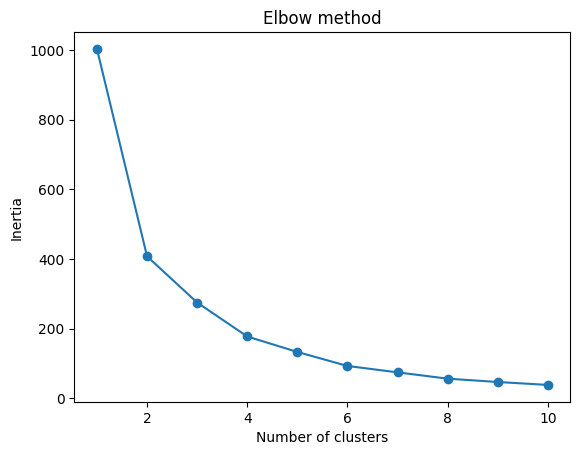

In [11]:
elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=2. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 2.
Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.</div>

In [12]:
silhouette_method(X)

Silhouette score: 0.486 (k = 2)
Silhouette score: 0.423 (k = 3)
Silhouette score: 0.457 (k = 4)
Silhouette score: 0.482 (k = 5)
Silhouette score: 0.511 (k = 6)
Silhouette score: 0.512 (k = 7)
Silhouette score: 0.514 (k = 8)
Silhouette score: 0.516 (k = 9)
Silhouette score: 0.508 (k = 10)


<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando este método podemos observar que tanto k=2 y k=6 son buenas opciones.</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

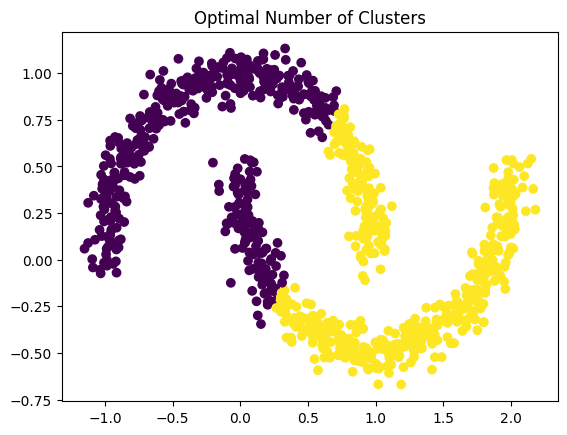

In [13]:
y_pred = KMeans(n_clusters=2).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Cuando los datos no están uniformemente distribuidos en todas las direcciones, es decir, tienen una distribución anisotrópica, el algoritmo K-means puede tener dificultades para agruparlos correctamente. Esto se debe a que K-means minimiza la suma de las distancias cuadradas entre cada punto y su centroide asignado, lo que puede llevar a que algunos puntos se asignen a centroides incorrectos si la distribución de los datos no es esférica.

En este caso, se hace necesario considerar algoritmos de clustering basados en densidad como DBSCAN, ya que estos algoritmos no se basan en la distancia euclidiana para definir los grupos, sino que consideran la densidad de puntos cercanos en el espacio. Debido a esto, los algoritmos basados en densidad son más adecuados para distribuciones anisotrópicas o para datos que no están claramente separados por límites claros o definidos.</div>

In [14]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

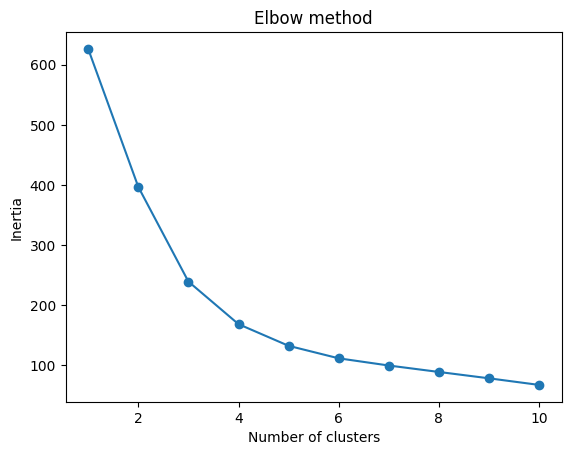

In [15]:
elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=3. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 3.
Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.</div>

In [16]:
silhouette_method(X)

Silhouette score: 0.354 (k = 2)
Silhouette score: 0.393 (k = 3)
Silhouette score: 0.381 (k = 4)
Silhouette score: 0.361 (k = 5)
Silhouette score: 0.341 (k = 6)
Silhouette score: 0.313 (k = 7)
Silhouette score: 0.356 (k = 8)
Silhouette score: 0.378 (k = 9)
Silhouette score: 0.434 (k = 10)


<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando este método podemos observar k=3 es una buena opción.</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

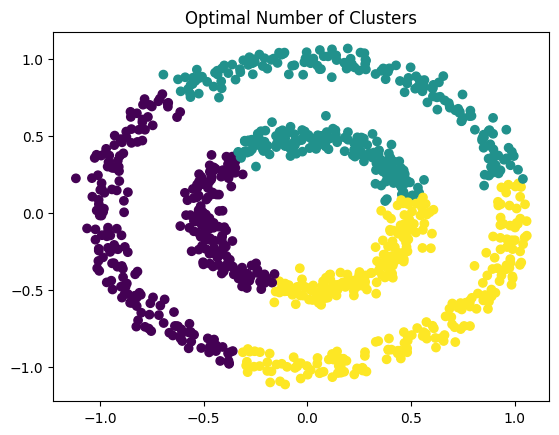

In [17]:
y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Debido a que los datos poseen una distribución de datos de dos circunferencias concentricas, K-means no es adecuado para identificar los grupos con precisión, ya que los grupos no se pueden separar claramente con una línea recta. Esto se debe a que K-means es un algoritmo de clustering basado en centroides que funciona mejor cuando los grupos tienen formas más simples y se pueden separar fácilmente con líneas rectas o planos. Por lo tanto, en casos como este, se recomienda el uso de algoritmos de clustering basados en la densidad de los datos, como DBSCAN.</div>

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [201]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [19]:
from sklearn.cluster import DBSCAN
from itertools import product
import seaborn as sns

In [202]:
def dbscan_method(X, eps_values=[0.3],min_samples=[3]):
    DBSCAN_params = list(product(eps_values, min_samples))

    no_of_clusters = []
    DBSCAN_params_new = []

    for p in DBSCAN_params:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
        no_cluster= len(np.unique(DBS_clustering.labels_))

        if no_cluster == 1: 
            #DBSCAN_params.remove(p)
            continue

        DBSCAN_params_new.append(p)
        no_of_clusters.append(no_cluster)
    
    return  no_of_clusters,DBSCAN_params_new

eps_values = np.arange(0.5,8,0.25) # grid eps value
min_samples = np.arange(5,15) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">
Se ha representado una tabla de loc lusteres dependiendo de los parámetros escogidos.
</div>

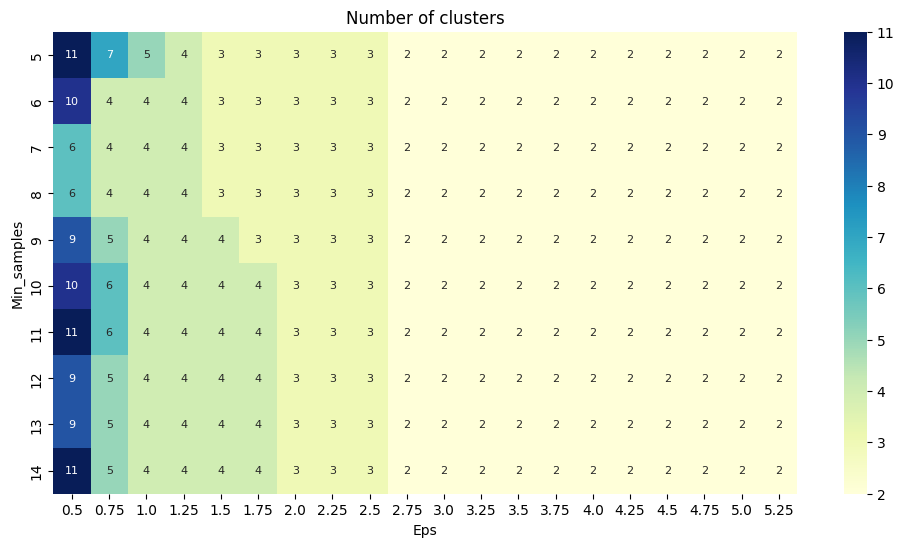

In [203]:
# Pivo table os the clusters
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

# HeatMap 
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 8}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

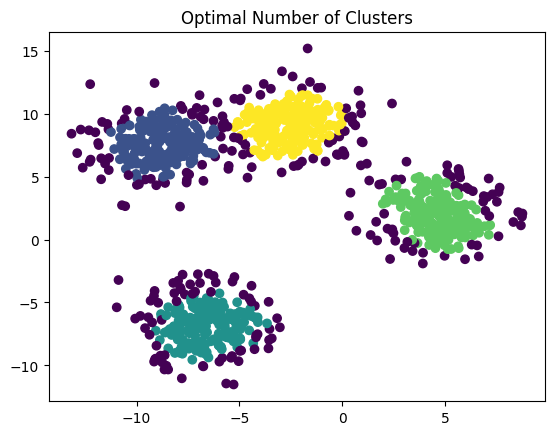

In [207]:
y_pred = DBSCAN(eps=0.75, min_samples=12).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando los hiperparámetros: eps=0.75 y min_samples=12 obtenemos 4 clústeres distintos, además de la identificación de los outliers (puntos en morado).</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">
Se ha realizado un intento para identificar el número óptimo de clusters utilizando un gridSearch del modelo con diferentes valores de los hiperparámetros eps y min_samples. Este algoritmo agrupa los puntos que se encuentran cercanos entre sí, utilizando la distancia Euclidiana como base. Cabe destacar que al establecer el valor de eps, estamos indicando la distancia máxima permitida entre dos puntos para que sean asignados al mismo cluster, mientras que el valor de min_samples indica el número mínimo de puntos requeridos para formar un cluster. Como resultado, aquellos valores que no pueden ser asignados a un cluster automáticamente son considerados como outliers (cluster = -1), los cuales se representan como puntos morados en el gráfico obtenido.

En mi opinión, el resultado ha sido bastante satisfactorio y esto se debe en gran parte al gridSearch que se llevó a cabo previamente. Este proceso redujo significativamente la cantidad de trabajo que se necesitaba hacer para probar diferentes combinaciones de hiperparámetros. Sin embargo, al utilizar un valor de eps pequeño, muchos de los puntos se clasificaron erróneamente como outliers, aunque en realidad no lo eran. Peor si aumentáramos el valor de eps, los grupos superpuestos no se se diferenciarian adecuadamente.
</div>

In [208]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [209]:
eps_values = np.arange(0.1,2,0.05) # grid eps value
min_samples = np.arange(2,8) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)

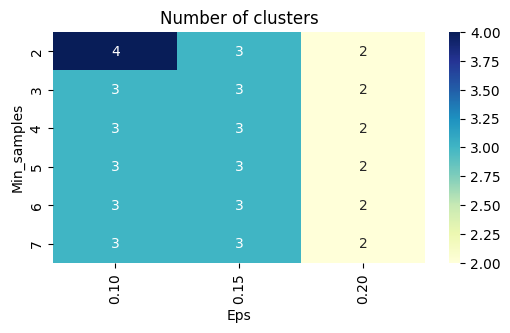

In [210]:
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
# Format x-axis decimals
ax.set_xticklabels(['{:.2f}'.format(x) for x in pivot_1.columns])
ax.set_title('Number of clusters')
plt.show()

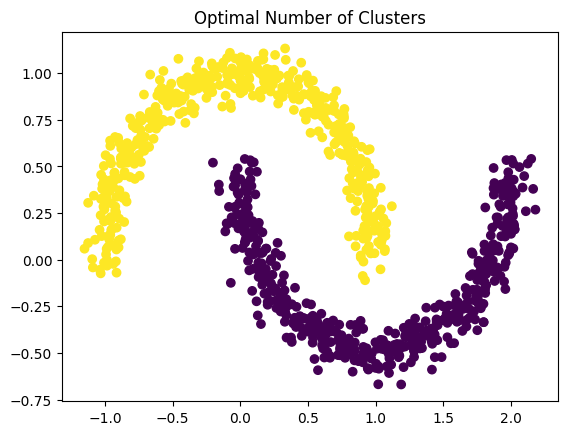

In [222]:
y_pred = DBSCAN(eps=0.2, min_samples=20).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

In [223]:
np.unique(y_pred)

array([0, 1])

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando los hiperparámetros: eps=0.2 y min_samples=20 obtenemos 2 clústeres distintos, además de que no se ha identificado ningún outlier en el conjunto de los datos.</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">
Como se mencionó anteriormente, el conjunto de datos analizado presenta una distribución anisotrópica. En este tipo de distribuciones, el algoritmo DBSCAN tiene un mejor desempeño debido a su capacidad de no asumir una forma particular para los grupos, sino que utiliza la densidad de los datos para identificarlos. Esto le permite detectar grupos con formas arbitrarias y adaptarse a diferentes escalas y densidades de los datos, lo que es especialmente útil en distribuciones anisotrópicas donde los grupos pueden tener formas y tamaños variables.

Además, DBSCAN es menos sensible a los valores atípicos y al ruido, lo que lo hace una buena opción para datos de este tipo. Sin embargo, para obtener un buen resultado en la tarea de clustering, es importante ajustar los parámetros del algoritmo. El grid search es una técnica que permite encontrar los valores óptimos de los parámetros, lo que mejora significativamente el rendimiento del algoritmo.

En resumen, el buen resultado obtenido en el clustering se debe a la adecuación del algoritmo DBSCAN para tratar distribuciones anisotrópicas, así como al uso del gridSearch para encontrar los hiperparámetros óptimos del algoritmo.
</div>

In [224]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [225]:
eps_values = np.arange(0.1,3,0.05) # grid eps value
min_samples = np.arange(2,10) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)

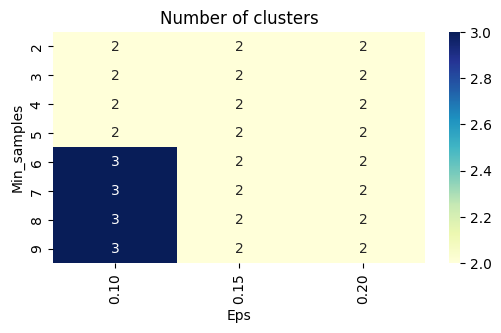

In [226]:
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
# Format x-axis decimals
ax.set_xticklabels(['{:.2f}'.format(x) for x in pivot_1.columns])
ax.set_title('Number of clusters')
plt.show()

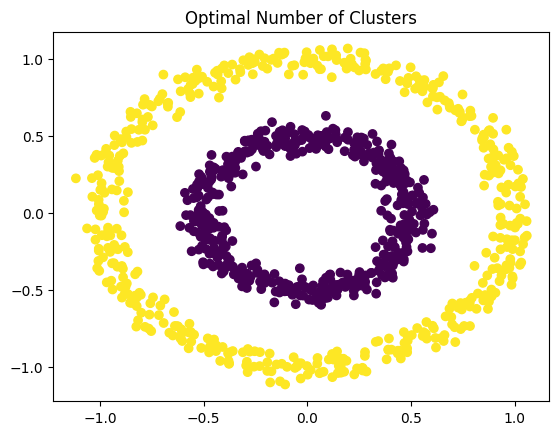

In [240]:
y_pred = DBSCAN(eps=0.15, min_samples=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

In [241]:
np.unique(y_pred)

array([0, 1])

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Usando los hiperparámetros: eps=0.15 y min_samples=9 obtenemos 2 clústeres distintos, además de que no se ha identificado ningún outlier en el conjunto de los datos.</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">
Como ya se mencionó previamente, el conjunto de datos analizado tiene una distribución anisotrópica. En este tipo de distribuciones, el algoritmo DBSCAN es una opción adecuada para la tarea de clustering.

El gráfico obtenido muestra que el clustering ha logrado un buen desempeño. Este resultado se debe, en gran medida, a la capacidad del algoritmo DBSCAN para tratar distribuciones anisotrópicas, lo que le permite detectar grupos con formas variables y adaptarse a diferentes escalas y densidades de los datos.

Además, se utilizó la técnica de gridSearch para encontrar los hiperparámetros óptimos del algoritmo, lo que contribuyó a mejorar aún más el rendimiento del clustering. En resumen, el buen resultado obtenido es el resultado de la adecuación del algoritmo DBSCAN para tratar distribuciones anisotrópicas y del uso del gridSearch para optimizar los hiperparámetros del algoritmo.
</div>

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [250]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

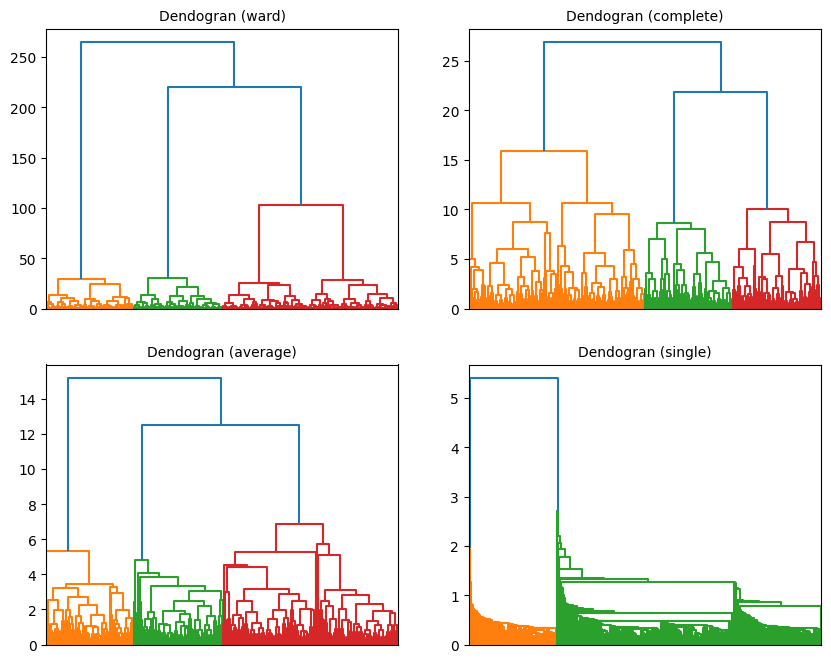

In [251]:
import scipy.cluster.hierarchy as sch

def dendogram_all_links(X,linkages=['ward', 'complete', 'average', 'single']):
    plt.figure(figsize=(10,8))
    for i,link in enumerate(linkages,1):
        plt.subplot(2,2,i)
        dendrogram = sch.dendrogram(sch.linkage(X, method = link))
        title = 'Dendogran ({})'.format(link)
        plt.title(title, fontsize = 10)
        plt.xticks([])
    plt.show()

dendogram_all_links(X)

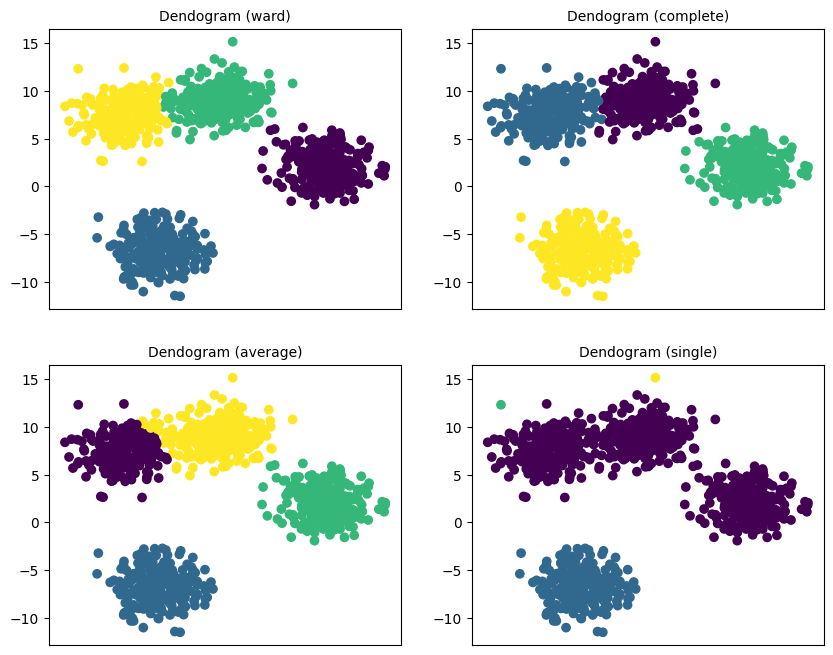

In [252]:
from sklearn.cluster import AgglomerativeClustering

def agglomerativeClustering_all_linkages(X,k,linkages=['ward', 'complete', 'average', 'single']):
    plt.figure(figsize=(10,8))
    for i,link in enumerate(linkages,1):
        plt.subplot(2,2,i)
        cluster_model = AgglomerativeClustering(n_clusters=k, linkage=link)
        y_pred = cluster_model.fit_predict(X)
        plt.scatter(X[:, 0], X[:, 1], c=y_pred)
        title = 'Dendogram ({})'.format(link)
        plt.title(title, fontsize = 10)
        plt.xticks([])
    plt.show()

agglomerativeClustering_all_linkages(X,4)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Para este conjunto de datos, el dendrograma muestra claramente la existencia de cuatro grupos distintos. Cada grupo se representa en el dendrograma como una de las cuatro ramas principales, que a su vez se dividen en subgrupos más pequeños a medida que se desciende en la jerarquía.

Existen varios criterios de enlace que se pueden utilizar en el clustering jerárquico, como el Ward, el completo, el simple, entre otros. Cada uno puede ser más adecuado para diferentes tipos de datos, dependiendo de la estructura de los grupos.

En el caso de los datos utilizados en este ejemplo, tanto el criterio de enlace Ward, completo y promedio han demostrado ser eficaces para agrupar los datos correctamente, lo que se puede observar en la estructura clara y definida del dendrograma. Por otro lado, el criterio de enlace "single" ha demostrado no ser adecuado para estos datos, ya que ha agrupado incorrectamente algunos de los puntos, debido a que los grupos están cercanos entre sí y este criterio solo tiene en cuenta las distancias mínimas entre los puntos.</div>

In [253]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

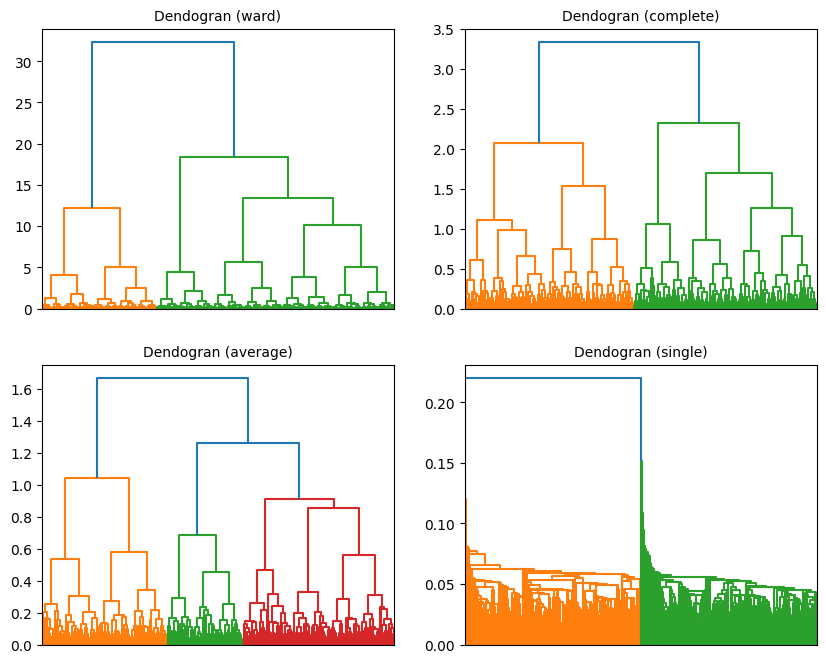

In [254]:
dendogram_all_links(X)

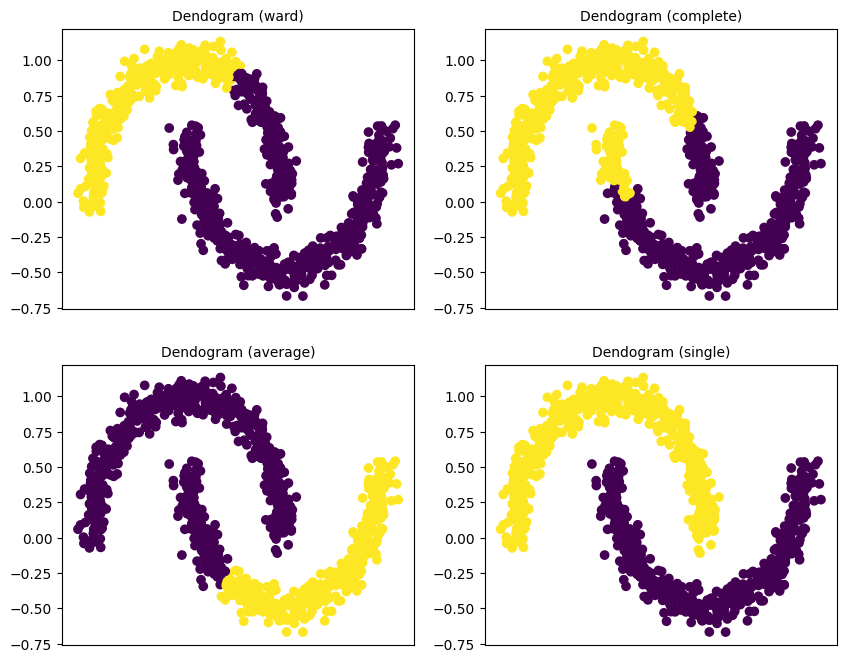

In [255]:
agglomerativeClustering_all_linkages(X,2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Para este conjunto de datos, el dendrograma muestra la estructura jerárquica de agrupación de los datos, donde la altura a la que se unen dos grupos indica la distancia entre los mismos. El dendrograma muestra claramente la existencia de dos grupos distintos, que se dividen en subgrupos más pequeños a medida que se desciende en la jerarquía.

En el caso de los datos utilizados en este ejemplo, los criterios de enlace Ward, complete y average pueden no ser los más apropiados debido a la distribución no esférica de los datos, pero pueden ser eficaces en otros conjuntos de datos con distribuciones esféricas. Por otro lado, el criterio de enlace single ha demostrado ser eficaz para estos datos con distribuciones no esféricas o irregulares, ya que utiliza la distancia mínima entre dos puntos de los grupos que se están uniendo, lo que puede ser beneficioso en conjuntos de datos donde los grupos tienen formas irregulares o no esféricas.</div>

In [257]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

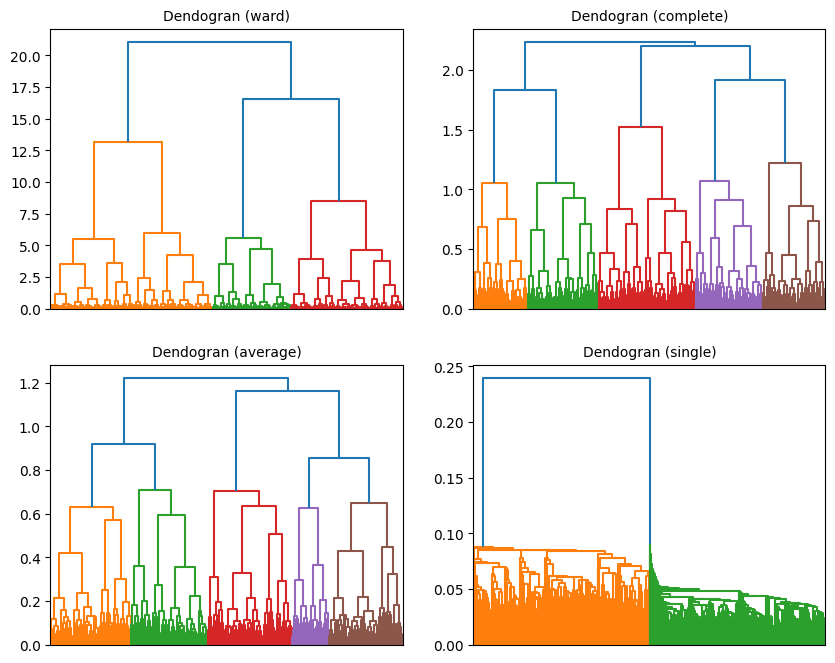

In [258]:
dendogram_all_links(X)

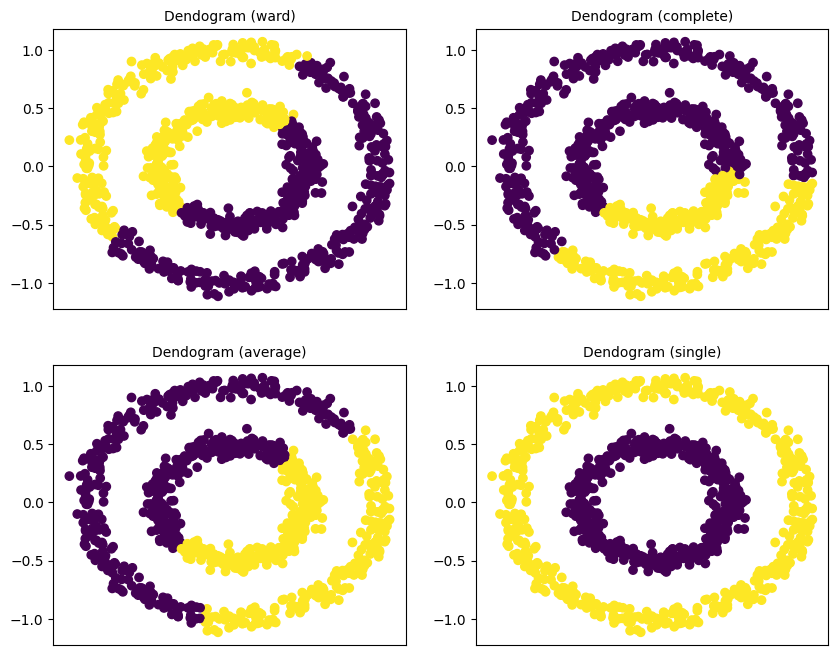

In [261]:
agglomerativeClustering_all_linkages(X,2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">En este caso, el dendrograma muestra claramente dos grupos principales que se dividen en subgrupos más pequeños a medida que se desciende en la jerarquía.

Es importante destacar que no existe un criterio de enlace único que funcione mejor en todos los casos, ya que esto depende de la distribución de los datos y del objetivo del análisis. Por ejemplo, los criterios de enlace "Ward", "complete" y "average" pueden ser eficaces para conjuntos de datos con distribuciones esféricas, pero pueden no ser los más apropiados para conjuntos de datos con distribuciones no esféricas o irregulares, como en este caso. El criterio con mejor reusultado ha sido el "single".</div>


<a id="ej2"></a>

## 2. Aplicación para comprimir imágenes (3 puntos)

Las imágenes en color se componen de píxeles que tienen tres componentes (roja, azul y verde), destinando 1 *byte* a cada canal. Pudiendo representar $2^8 = 256$ rojos, verdes y azules. Con un total de $2^{8^{3}} = 2^{24} = 16777216$ colores representables en cada píxel.

Entre mayor sea el número de colores representables, más memoria será necesaria para almacenar la imagen.
Por tanto, una estrategia para comprimir una imagen puede ser disminuir los colores representables en cada píxel, necesitando menos *bits* para guardar el valor de un píxel. Este método no es reversible, es decir, no se puede volver a recuperar la imagen original a partir de la comprimida. Por tanto, este tipo de compresiónse denomina [comprensión con pérdidas](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Pero ¿cómo seleccionamos los "píxeles parecidos" en la imagen original y determinamos su color en la imagen comprimida?. Una opción es utilizar *k-means* donde **$k$ será el número de colores representables**, los puntos que pertenecen a cada cluster equivaldrían a los "píxeles parecidos" y las coordenadas de los **centroides actuarán como los colores finales** a los que se aproximarán los "píxeles parecidos".

Como resultado del clustering, se obtiene una paleta de colores reducida (coordenadas de los centroides) donde cada píxel de la imagen hará referencia a uno de estos colores (cluster al que pertenece). El uso de paletas de colores o [colores indexados](https://en.wikipedia.org/wiki/Indexed_color) es un recurso empleado por distintos formatos de imagen como *PNG*, *GIF* o *TIFF*.

Si no dispones de la librería ``skimage`` puedes instalarla:
 - Usando conda (si has creado tu entorno virtual con conda): ``conda install scikit-image``
 - Usando pip: ``pip install scikit-image``

Imagen con 65536 pixeles (196608 bytes)


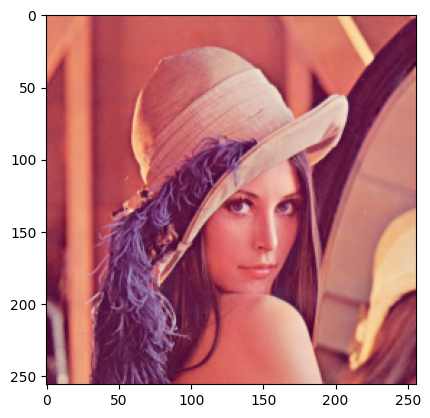

In [262]:
from skimage import io, transform

photo = (transform.resize(
    io.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'),
    (256, 256), mode='edge') * 255).astype(np.uint8)
plt.imshow(photo)        # np.array con shape (256, 256, 3), alto por ancho por 3 (los tres canales: rojo, verde y azul), donde cada valor ocupa un byte.
X = photo.reshape(-1, 3) # np.array con shape (65536, 3), cada pixel con sus 3 canales
print('Imagen con {} pixeles ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Para facilitar la tarea, la imagen anterior está guardada en un *array* con tantas filas como píxeles y columnas como canales (rojo, verde y azul). De forma que cada "muestra" equivale al valor de un píxel.

Se puede volver a recomponer la imagen original con:
```
plt.imshow(X.reshape(photo.shape))
```
Podemos ver cada píxel como un punto en un sistema de coordenadas de 3 dimensiones donde una es su cantidad de rojo, otra su cantidad de verde y por último su cantidad de azul. Por lo que podemos realizar una visualización en 3 dimensiones de los píxeles sobre la que se probará el algoritmo de clustering:

In [263]:
X

array([[225, 136, 125],
       [223, 136, 129],
       [225, 133, 118],
       ...,
       [166,  69,  84],
       [177,  68,  78],
       [182,  72,  80]], dtype=uint8)

Para visualizar la animación de la representación 3D de los píxeles es necesario instalar la librería ``ffmpeg``.

Si tienes un entorno virtual de conda, lo puedes instalar con: ``conda install -c conda-forge ffmpeg``.

**Si tienes un error**, puedes ver una representación estática 2 celdas más adelante.

In [264]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['animation.html'] = 'html5'

idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .2))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')

def animate(i):
    ax.view_init(elev=20., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, frames=range(0, 360, 10), interval=200, blit=True)
anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

<Figure size 800x600 with 0 Axes>

Visualización estática del valor de los píxeles:

In [265]:
idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .3))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')
ax.view_init(20, 350)
plt.show()

<Figure size 800x600 with 0 Axes>

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (255, 255, 255) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros. También se observan 4 estructuras de píxeles: la pluma del sombrero, el sombrero, la piel de la modelo (Lenna) y el fondo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplicar <i>k-means</i> con <i>k=3</i> a los píxeles de la imagen (puntos con 3 dimensiones de la variable <i>X</i>) y obtener, para cada punto, su centroide más cercano. Y las coordenadas (3 dimensiones) de cada centroide.
</div>

In [194]:
X_standard = X/255
# KMeans para compimir la imagen
kmeans = KMeans(n_clusters=3, random_state=random_state)
cluster = kmeans.fit_predict(X_standard)

# Obtenermos las etiquetas de los cluters y los centroides de cada cluster
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [195]:
np.unique(cluster)

array([0, 1, 2], dtype=int32)

In [196]:
centers

array([[0.43362073, 0.13946204, 0.28585528],
       [0.87959866, 0.64560803, 0.56909441],
       [0.76229298, 0.38013537, 0.39292436]])

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> asgina a cada punto (píxel de la imagen) el valor de su centroide asociado en lugar de su propio valor.
</div>

In [197]:
new_image = centers[cluster]

In [198]:
new_image.reshape(photo.shape).nbytes

1572864

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> volver a convertir el resultado en una imagen usando la función <i>reshape</i> (como cuando se creó X) para que vuelva a tener su dimensión de <i>256 x 256</i>. Y mostrarla con <i>imshow</i>.
</div>

(-0.5, 255.5, 255.5, -0.5)

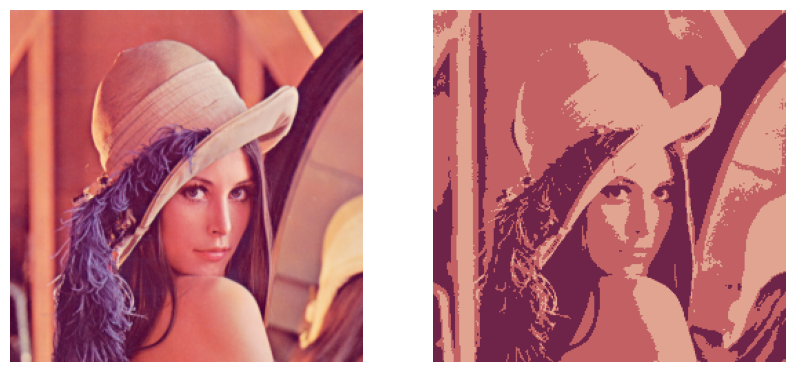

In [118]:
fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(photo)
ax[0].axis('off')
plt.imshow(new_image.reshape(photo.shape))
ax[1].axis('off')

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿por qué se ha producido este resultado?, ¿qué relación tiene con el clústering?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">Al aplicar el algoritmo de k-means con k=3 a la imagen, se ha logrado la segmentación de los valores de los píxeles de la imagen en tres grupos distintos, cada uno representando un clúster o segmento de la imagen. Como la imagen está codificadas en formato RGB, cada píxel contiene tres valores que representan la intensidad de rojo, verde y azul. Como resultado de la segmentación, se obtienen tres centroides de clusteres, los cuales representan los colores dominantes en la imagen. Utilizando estos colores, se puede crear una nueva imagen que tenga una apariencia similar a la original, pero con una reducción en la cantidad de colores utilizados en la misma.</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realizar el proceso anterior para distintos valores de <i>k</i>: 256, 128, 64, 32, 16, 8, 4 y 2 colores. Mostrar las imágenes e indicar los bytes que ocuparía cada una de las opciones.
</div>

In [127]:
def image_kmeans_compression(X,k=3,random_state=170):
    X_standard = X/255
    # KMeans para compimir la imagen
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster = kmeans.fit_predict(X_standard)
    # Obtenermos los centroides de cada cluster
    centers = kmeans.cluster_centers_
    # New image
    new_image = centers[cluster]
    # Size in bytes
    size_bytes = new_image.nbytes
    return new_image, size_bytes

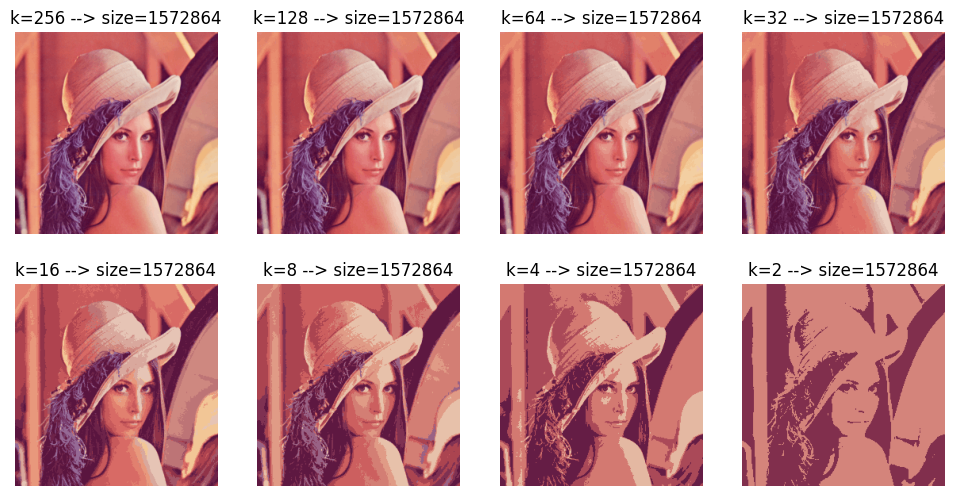

In [181]:
ks = [256, 128, 64, 32, 16, 8, 4, 2]
plt.figure(figsize=(12,6))
for i,k in enumerate(ks,1):
    plt.subplot(2,4,i)
    new_image, size_bytes = image_kmeans_compression(X,k)
    plt.imshow(new_image.reshape(photo.shape))
    title = 'k={} --> size={}'.format(k,size_bytes)
    plt.title(title)
    plt.axis('off')
plt.show()

<a id="ej3"></a>

## 3. Aplicación de reducción de dimensionalidad para resolver un problema de optimización: t-SNE (2 puntos)

Como ya se ha visto, el algoritmo [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideado por [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difiere de PCA en que no trata de maximizar la varianza explicada. Intuitivamente, t-SNE trata de que la vecindad de un punto en baja dimensionalidad sea la misma que la original (mantenga las distancias). Partiendo de una localización aleatoria de cada punto, corrige su posición de forma iterativa tratando de minimizar la distancia a sus vecinos originales hasta converger.

Para ello, t-SNE dispone de diversos [parámetros](https://distill.pub/2016/misread-tsne/) que pueden modificar drásticamente el resultado. Por lo que se recomienda conocer su funcionamiento antes de aplicar la técnica.

Partiendo de las distancias entre las [provincias de España](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presentes en el fichero de datos (en *pec2_3.p* un *DataFrame* de *pandas* en formato *pickle* o *pec2_3.csv* en formato *CSV*). Se pide calcular la matriz cuadrada que contenga la distancia de cada provincia contra las demás.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> la matriz debe tener tantas filas y columnas como provincias. Y cada celda debe contener la distancia entre las provincias de esa fila y columna.
</div>

In [266]:
df = pd.read_pickle('pec2_3.p')
df.head()

,from,to,dist
0,A Coruña,A Coruña,0.000000
1,A Coruña,Albacete,724.856651
2,A Coruña,Alicante/Alacant,846.212163
3,A Coruña,Almería,840.615943
4,A Coruña,Asturias,203.994866


In [267]:
df_pivot = pd.pivot_table(df, index='from', columns='to', values='dist')
df_pivot.head(5)

to,A Coruña,Albacete,Alicante/Alacant,Almería,Asturias,Badajoz,Barcelona,Burgos,Cantabria,Castellón/Castelló,...,Tarragona,Teruel,Toledo,Valencia/València,Valladolid,Vizcaya,Zamora,Zaragoza,Álava,Ávila
from,,,,,,,,,,,,,,,,,,,,,
A Coruña,0.000000,724.856651,846.212163,840.615943,203.994866,532.145376,876.649134,410.217119,367.135855,762.201706,...,808.380255,686.035068,502.609834,788.375067,341.775029,459.120176,265.019803,616.475388,473.058961,401.053193
Albacete,724.856651,0.000000,133.167945,198.373164,602.411733,368.490804,456.300748,400.075482,516.518488,202.556989,...,352.478721,219.562855,230.794941,126.278287,394.458647,493.407420,460.527619,302.157283,436.338317,326.357718
Alicante/Alacant,846.212163,133.167945,0.000000,232.662010,708.828268,496.514068,407.550071,491.342441,602.775844,179.985456,...,315.469036,241.358580,361.648487,83.901967,508.482111,562.454583,581.223032,343.237317,506.485555,453.163512
Almería,840.615943,198.373164,232.662010,0.000000,753.394401,369.104671,632.381406,576.019713,693.069983,384.955553,...,533.478566,416.103697,344.665423,289.162304,541.630208,681.728647,588.912271,500.358089,625.207844,446.124144
Asturias,203.994866,602.411733,708.828268,753.394401,0.000000,520.694031,681.616080,229.710582,164.251031,596.501705,...,621.344995,516.468233,410.803414,640.210776,211.942406,256.054120,181.268009,434.042842,275.452508,314.346015


Una vez que se cuenta con la matriz de distancias, *t-SNE* tratará de mantener esas distancias entre los distintos puntos en baja dimensionalidad (en este caso 2 dimensiones). Emplazando los puntos en el plano mientras intenta mantener las distancias indicadas.

Dado que la entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se le pasa la matriz de distancias, no es necesario que las calcule. Por ello le indicaremos que la métrica a emplear es "precalculada".

Como *t-SNE* es un algoritmo estocástico (dos ejecuciones consecutivas con los mismos datos pueden conducir a resultados diferentes). Se pide realizar el proceso de ajuste con *t-SNE* 100 veces y quedarse con la ejecución con menor error (ver el atributo [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> jugar con los hiperparámetros de <i>t-SNE</i>, ejecutar 100 veces el ajuste de <i>t-SNE</i> y guardar el resultado de emplazamiento de provincias en el plano de la ejecución con menor error.
</div>

In [168]:
from sklearn.manifold import TSNE

# Reducir dimensionalidad con t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', square_distances=True, metric="precomputed")
kl_divergences = []
for i in range(100):
    df_tsne = tsne.fit_transform(df_pivot)
    kl_divergence = tsne.kl_divergence_
    kl_divergences.append(kl_divergence)
    if kl_divergence == min(kl_divergences):
        best_TSNE = pd.DataFrame(data=tsne.fit_transform(df_pivot, ), columns=['C1', 'C2'],index=df_pivot.index)


print(f"El df_tsne de menor error (kl_divergence={min(kl_divergences)}) es:")
best_TSNE.head()

El embedding de menor error (kl_divergence=0.028016189113259315) es:


,C1,C2
from,,
A Coruña,-4.291261,10.138195
Albacete,-2.512038,6.293667
Alicante/Alacant,-2.680420,5.650422
Almería,-1.426087,6.219310
Asturias,-4.795498,9.357215


Una vez que se tienen las posiciones de las provincias en el plano, visualizar el resultado y analizar si el emplazamiento de las provincias calculado por *t-SNE* calculado en base a las distancias se parece al real.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> visualizar en un <i>scatter</i> las provincias de la ejecución con menor error, junto con su nombre para poder analizarlo.
</div>

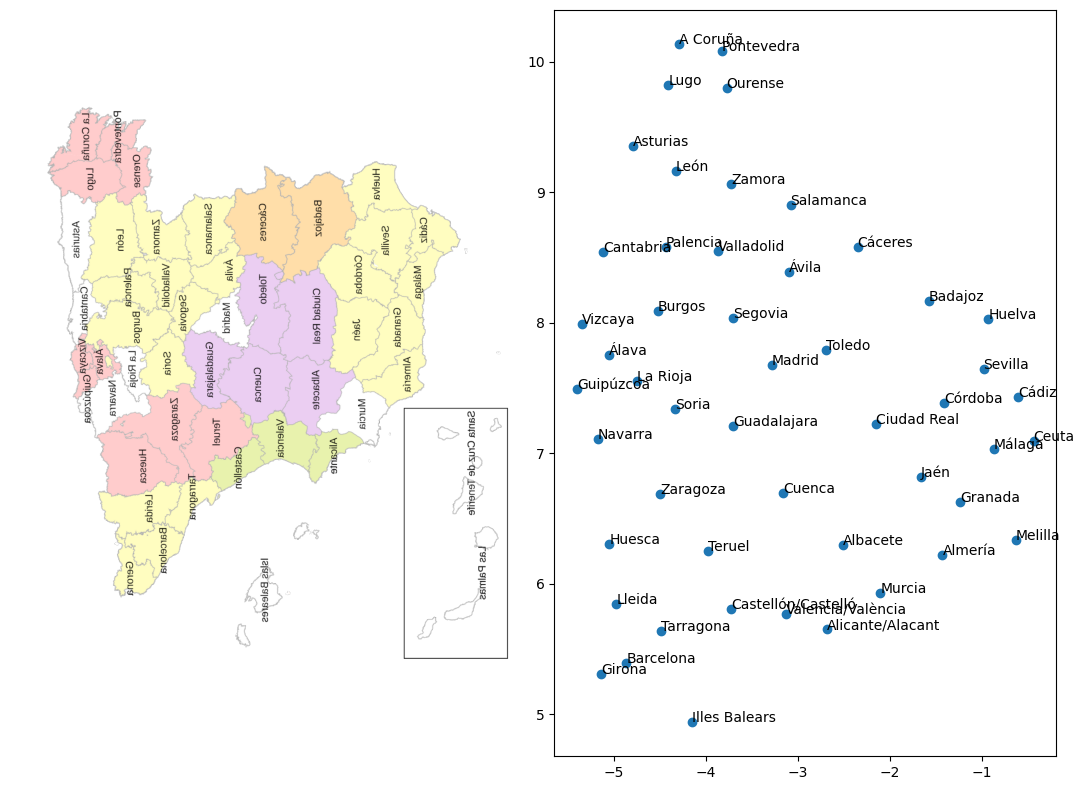

In [180]:
from PIL import Image
imagen_mapa = Image.open('Provinciasesp.png')

fig, ax = plt.subplots(1, 2,  figsize=(11, 8))

ax[0].imshow(imagen_mapa)
ax[0].axis('off')
# etiquetar cada fila con su índice
best_TSNE['provincia'] = best_TSNE.index
ax[1].scatter(best_TSNE['C1'], best_TSNE['C2'])
for i, etiqueta in enumerate(best_TSNE['provincia']):
    ax[1].annotate(etiqueta, (best_TSNE['C1'][i], best_TSNE['C2'][i]))
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿se parece a la distribución de provincias real?, ¿por qué?
</div>

<div style="border-color: #7C9DBF; border-left: 5px solid rgb(8, 20, 22); background-color:#e6b3b8;background-color:rgb(212, 217, 219); padding: 0.5em;">El resultado de t-SNE se parece al mapa real de España porque t-SNE busca preservar la estructura de similitud entre los puntos en el espacio de baja dimensión. En este caso, los puntos son las provincias y la similitud entre ellas es su distancia.

En el espacio de alta dimensión (la matriz de distancias), las provincias que están más cerca entre sí tienen una distancia menor que las que están más lejos. En el espacio de baja dimensión, t-SNE intenta preservar esta estructura de similitud, de manera que las provincias que están más cerca en la matriz de distancias también están más cerca en el espacio de 2 dimensiones generado por t-SNE.

Como la posición geográfica de las provincias de España está altamente correlacionada con su distancia, t-SNE logra generar una estructura que se parece al mapa real de España, con las provincias agrupadas de manera similar a como están geográficamente en la realidad.
</div>